# Phase Identification NN

Developement of a neural network capable of identifying the phase of a 2D system (liquid, hexatic or solid)

In [2]:
import tensorflow as tf

import glob
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2023-01-21 18:24:31.951188: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-21 18:24:32.271514: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-21 18:24:32.321743: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-21 18:24:32.321760: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

2.11.0


## Load data

First, let us load the data

In [7]:
# loop over all the runs
train_data = []
train_labels = []

path = 'ordered_128/Pe0'
conf_counter = 0


for fi in glob.glob(path + '/fi*'):
    # extract the density from the path name
    #print(fi)
    density, run = tuple(fi.split('/')[2].split('_'))
    density = float(density.split('fi')[1])
    print(density, run)
    # loop over all the trajectories
    phase_label = 0 # liquid
    if density >= 0.705:
        phase_label = 1
    # if density >= 0.725:
    #     phase_label = 2   # this is the "pure" hexatic phase
                            # for the moment we will not use it
    if density >= 0.726:
        phase_label = 2
    #print(phase_label)
    
    for j, trj in enumerate(glob.glob(fi + '/Trj/xyz.dump.*')):
        #if j>50:
        #    break
        # load the trajectory
        #print(phase_label, trj)
        data = np.loadtxt(trj, skiprows=9)
        
        xmax = np.max(data[:,1])
        ymax = np.max(data[:,2])

        data[:,1] = data[:,1] / xmax
        data[:,2] = data[:,2] / ymax

        if train_labels.count(phase_label) < 500:

            train_data.append(data[:,[1,2]])
            train_labels.append(phase_label)

            conf_counter += 1

        # setting limits on the number of confs for each label
        
print("Total configurations: ", conf_counter)
for i in range(3):
    print("Number of configurations for phase ", i, " is ", train_labels.count(i))

0.708 8
0.722 7
0.702 6
0.732 1
0.704 8
0.729 1
0.704 6
0.706 8
0.7 6
0.724 8
0.72 1
0.712 7
0.716 8
0.714 8
0.718 8
0.712 8
0.72 8
0.736 1
0.702 7
0.71 1
0.712 6
0.714 6
0.72 6
0.72 7
0.735 1
0.738 1
0.708 7
0.716 7
0.722 8
0.715 1
0.704 7
0.722 6
0.726 6
0.724 7
0.737 1
0.7 7
0.723 1
0.724 6
0.73 1
0.705 1
0.706 7
0.726 1
0.733 1
0.727 1
0.718 7
0.7 8
0.731 1
0.71 7
0.708 6
0.718 6
0.71 8
0.71 6
0.728 1
0.714 7
0.706 6
0.702 8
0.739 1
0.74 1
0.724 1
0.726 7
0.734 1
0.725 1
0.726 8
0.716 6
Total configurations:  1500
Number of configurations for phase  0  is  500
Number of configurations for phase  1  is  500
Number of configurations for phase  2  is  500


In [50]:
# loop over all the runs
test_data = []
test_labels = []

path = 'ordered_128/Pe0'
test_counter = 0

for i, fi in enumerate(glob.glob(path + '/fi*')):


    # extract the density from the path name
    #print(fi)
    density, run = tuple(fi.split('/')[2].split('_'))
    density = float(density.split('fi')[1])
    print(density, run)
    # loop over all the trajectories
    phase_label = 0 # liquid
    if density >= 0.705:
        phase_label = 1
    #if density >= 0.725:
    #    phase_label = 2
    if density >= 0.726:
        phase_label = 2
    
    for j, trj in enumerate(glob.glob(fi + '/Trj/xyz.dump.*')):
        if j <= 40:
            continue
        if phase_label != 2:
            if j > 61:
                break
        # load the trajectory
        #print(phase_label, trj)
        data = np.loadtxt(trj, skiprows=9)
        
        xmax = np.max(data[:,1])
        ymax = np.max(data[:,2])

        data[:,1] = data[:,1] / xmax
        data[:,2] = data[:,2] / ymax

        if test_labels.count(phase_label) < 100:
            test_data.append(data[:,[1,2]])
            test_labels.append(phase_label)
            test_counter += 1
        
print("Total configurations: ", test_counter)
for i in range(3):
    print("Number of configurations for phase ", i, " is ", test_labels.count(i))

0.708 8
0.722 7
0.702 6
0.732 1
0.704 8
0.729 1
0.704 6
0.706 8
0.7 6
0.724 8
0.72 1
0.712 7
0.716 8
0.714 8
0.718 8
0.712 8
0.72 8
0.736 1
0.702 7
0.71 1
0.712 6
0.714 6
0.72 6
0.72 7
0.735 1
0.738 1
0.708 7
0.716 7
0.722 8
0.715 1
0.704 7
0.722 6
0.726 6
0.724 7
0.737 1
0.7 7
0.723 1
0.724 6
0.73 1
0.705 1
0.706 7
0.726 1
0.733 1
0.727 1
0.718 7
0.7 8
0.731 1
0.71 7
0.708 6
0.718 6
0.71 8
0.71 6
0.728 1
0.714 7
0.706 6
0.702 8
0.739 1
0.74 1
0.724 1
0.726 7
0.734 1
0.725 1
0.726 8
0.716 6
Total configurations:  300
Number of configurations for phase  0  is  100
Number of configurations for phase  1  is  100
Number of configurations for phase  2  is  100


In [9]:
print(test_counter)
test_data = np.array(test_data)
test_labels = np.array(test_labels)

3


## Data selection


In [10]:
train_data = np.array(train_data)
train_labels = np.array(train_labels)

print(train_data.shape)
print(train_labels.shape)

(1500, 16384, 2)
(1500,)


[[0.73116102 0.97770978]
 [0.98406532 0.87208305]
 [0.07215987 0.79156818]
 ...
 [0.99054451 0.95805895]
 [0.93476149 0.88559644]
 [0.13102701 0.19516683]]


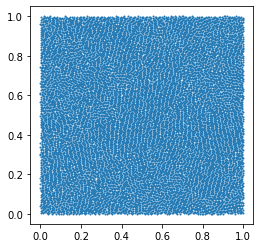

1


In [6]:
print(train_data[0])

plt.figure(figsize=(4,4))
#plt.xticks([])
#plt.yticks([])
plt.plot(train_data[1][:,0], train_data[1][:,1], 'o', markersize=1)
plt.show()
print(train_labels[1])


/tmp/ipykernel_201443/1773539401.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(smaller_boxes)


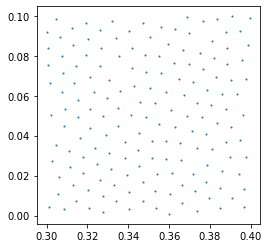

100


In [11]:
def split_sys_in_squares(pos, edge_size):
    '''This function takes in a list of x,y coordinates and splits them up into
    smaller boxes with the size of edge_size. The boxes are returned in a list.'''
    num_boxes = int(1 / edge_size)
    smaller_boxes = [[] for _ in range((num_boxes) * (num_boxes))]
    for x, y in pos:
        if x < 0 or y < 0 or x > 1 or y > 1:
            # Coordinates must be between 0 and 1.
            raise ValueError("Coordinates must be between 0 and 1.")
        box_x = int(x / edge_size) % num_boxes
        box_y = int(y / edge_size) % num_boxes
        #print(num_boxes * num_boxes + 1, box_x + box_y * num_boxes )
        smaller_boxes[box_x + box_y * num_boxes].append((x, y))
    
    for i in range(len(smaller_boxes)):
        smaller_boxes[i] = np.array(smaller_boxes[i])
    return np.array(smaller_boxes)

new_pos = split_sys_in_squares(train_data[0], 0.1)
#plt.plot(new_pos[5][:,0], new_pos[5][:,1], 'o', markersize=1)


def padding_conf(pos: np.ndarray):
    '''This function takes in a list of x,y coordinates and pads them with 
    zeros to make them all the same size. The padded coordinates are returned
    in a list.'''
    max_size = 0
    for i in range(len(pos)):
        if len(pos[i]) > max_size:
            max_size = len(pos[i])
    # print(max_size)
    padded_pos = np.zeros((len(pos), max_size, 2))
    for i in range(len(pos)):
        #print(i)
        padded_pos[i, :len(pos[i]), :] = pos[i]
    return padded_pos

def padding_conf_fixed_size(pos: np.ndarray, max_size: int):
    '''This function takes in a list of x,y coordinates and pads them with 
    zeros to make them all the same size. The padded coordinates are returned
    in a list.'''
    padded_pos = np.zeros((len(pos), max_size, 2))
    for i in range(len(pos)):
        padded_pos[i, :len(pos[i]), :] = pos[i]
    return padded_pos

padded_pos = padding_conf(new_pos)

#print(new_pos[3].shape)
#print(padded_pos[3].shape)
#print(padded_pos[3])

plt.figure(figsize=(4,4))
cellid = 3
data = padded_pos[cellid][padded_pos[cellid][:,0] != 0.0]
data = data[data[:,1] != 0.0]
plt.plot(data[:,0], data[:,1], 'o', markersize=1)
plt.show()

print(len(padded_pos))

In [13]:
# now split all the train set into smaller boxes with split_sys_in_squares
# and pad them with zeros with padding_conf
# then merge all the boxes into one big array

padded_train_data = []
for i in range(len(train_data)):
    new_pos = split_sys_in_squares(train_data[i], 0.2)
    padded_pos = padding_conf_fixed_size(new_pos, 756)
    padded_train_data.append(padded_pos)
    # print the completion percentage overwriting the same line
    if i % 100 == 0:
        print(i / len(train_data) * 100, '%\r', end='')


/tmp/ipykernel_201443/1773539401.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(smaller_boxes)


In [52]:

padded_test_data = []
for i in range(len(test_data)):
    new_pos = split_sys_in_squares(test_data[i], 0.2)
    padded_pos = padding_conf_fixed_size(new_pos, 756)
    padded_test_data.append(padded_pos)
    # print the completion percentage overwriting the same line
    if i % 100 == 0:
        print(i / len(test_data) * 100, '%\r', end='')

#padded_train_data = np.array(padded_train_data)

/tmp/ipykernel_201443/1773539401.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(smaller_boxes)


In [19]:
print(padded_train_data[4].shape)
padded_train_data = np.concatenate(padded_train_data, axis=0)
print(padded_train_data.shape)


(25, 756, 2)
(37500, 756, 2)
(25, 756, 2)
(5800, 756, 2)


In [53]:

print(padded_test_data[4].shape)
padded_test_data = np.concatenate(padded_test_data, axis=0)
print(padded_test_data.shape)

(25, 756, 2)
(7500, 756, 2)


In [21]:
print(len(padded_train_data))
print(len(train_labels))
# replicate each element in the train_labels array 100 times one after the other
padded_train_labels = np.repeat(train_labels, 25)


37500
1500
5800
232


In [54]:

print(len(padded_test_data))
print(len(test_labels))
padded_test_labels = np.repeat(test_labels, 25)

7500
300


## Set the model

In [55]:
print(padded_train_data.shape)

(37500, 756, 2)


In [56]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(756,2)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

In [59]:
from keras.optimizers import SGD
#opt = SGD()
#opt = SGD(learning_rate=0.0001)
opt = 'adam'

model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [60]:
history = model.fit(padded_train_data, padded_train_labels, validation_data=(padded_test_data, padded_test_labels), epochs=20)

Epoch 1/20
1172/1172 [==============================] - 6s 5ms/step - loss: 0.8547 - accuracy: 0.5644 - val_loss: 0.7356 - val_accuracy: 0.6025
Epoch 2/20
1172/1172 [==============================] - 5s 5ms/step - loss: 0.6748 - accuracy: 0.6590 - val_loss: 0.7115 - val_accuracy: 0.6428
Epoch 3/20
1172/1172 [==============================] - 5s 5ms/step - loss: 0.6246 - accuracy: 0.6790 - val_loss: 0.7487 - val_accuracy: 0.6351
Epoch 4/20
1172/1172 [==============================] - 5s 5ms/step - loss: 0.6043 - accuracy: 0.6906 - val_loss: 0.6151 - val_accuracy: 0.6837
Epoch 5/20
1172/1172 [==============================] - 5s 5ms/step - loss: 0.5924 - accuracy: 0.6965 - val_loss: 0.5937 - val_accuracy: 0.7260
Epoch 6/20
1172/1172 [==============================] - 6s 5ms/step - loss: 0.5767 - accuracy: 0.7081 - val_loss: 0.5776 - val_accuracy: 0.7283
Epoch 7/20
1172/1172 [==============================] - 6s 5ms/step - loss: 0.5873 - accuracy: 0.7000 - val_loss: 0.5777 - val_accuracy:

In [61]:
model.evaluate(padded_test_data, padded_test_labels)

235/235 [==============================] - 0s 1ms/step - loss: 0.5224 - accuracy: 0.7561


[0.5223626494407654, 0.7561333179473877]

In [62]:
# probability_model = tf.keras.Sequential([model, 
#                                          tf.keras.layers.Softmax()])
predictions = model.predict(padded_test_data)

235/235 [==============================] - 0s 1ms/step


In [47]:
def print_test_density(index):
    index = index % 100
    path = 'ordered_128/Pe0'
    test_fi = glob.glob(path + '/fi*')[index]
    # extract the density from the path name
    #print(fi)
    density, run = tuple(test_fi.split('/')[2].split('_'))
    density = float(density.split('fi')[1])
    # loop over all the trajectories
    phase_label = 0 # liquid
    if density > 0.705:
        phase_label = 1
    if density > 0.722:
        phase_label = 2
    if density > 0.725:
        phase_label = 3
    
    print(density, phase_label)

In [63]:
index = 1003
print(padded_test_labels[index])
print(predictions[index])
print_test_density(index)

1
[2.6744071e-01 7.2712570e-01 5.4335729e-03 1.6833702e-13]
0.732 3


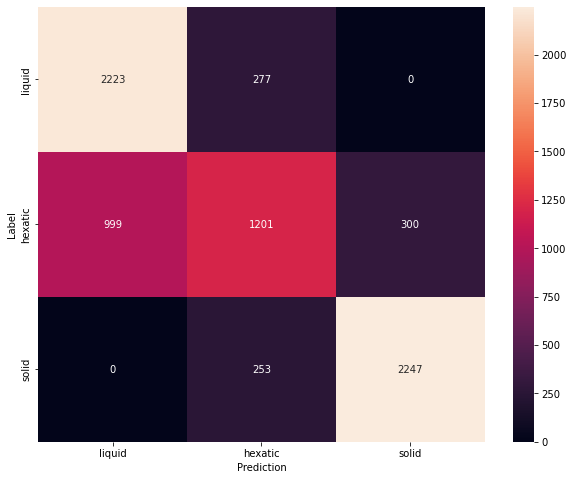

In [64]:
import seaborn as sns

def show_confusion_matrix(cm, labels):
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, xticklabels=labels, yticklabels=labels, 
              annot=True, fmt='g')
  plt.xlabel('Prediction')
  plt.ylabel('Label')
  plt.show()

confusion_mtx = tf.math.confusion_matrix(
    padded_test_labels, np.argmax(predictions, axis=1), num_classes=3, dtype=tf.dtypes.int32, name=None
)

show_confusion_matrix(confusion_mtx, ['liquid', 'hexatic', 'solid'])

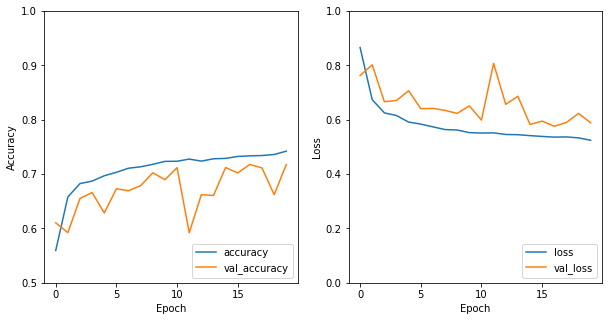

In [33]:
# plot the time evolution of the accuracy and loss
def plot_history(history):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.show()

plot_history(history) 